In [1]:
from numpy import argmax
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, PrecisionRecallDisplay, auc, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier


## Precision-Recall Curves - For When ROC Fails

Okay, hopefully you've all seen and get ROC-AUC by now. The ROC-AUC is a great tool for assessing your model's overall performance and for finding the right threshold for a classification model. But!  It does have some limitations. Let's explore that.

#### First thing, getting a dataset

In [2]:
data = sns.load_dataset('taxis')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pickup           6433 non-null   object 
 1   dropoff          6433 non-null   object 
 2   passengers       6433 non-null   int64  
 3   distance         6433 non-null   float64
 4   fare             6433 non-null   float64
 5   tip              6433 non-null   float64
 6   tolls            6433 non-null   float64
 7   total            6433 non-null   float64
 8   color            6433 non-null   object 
 9   payment          6389 non-null   object 
 10  pickup_zone      6407 non-null   object 
 11  dropoff_zone     6388 non-null   object 
 12  pickup_borough   6407 non-null   object 
 13  dropoff_borough  6388 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 703.7+ KB


In [3]:
data.color.value_counts()

yellow    5451
green      982
Name: color, dtype: int64

Okay, here's a dataset dealing with various taxi rides. Our client is a graphic designer who wants to comparing yellow and green cabs. For some reason, known as 'I need an example', they want to try to predict the color of a cab based on other factors of a cab ride. Since I'm just doing an example to show metrics and I'm not trying to incorporate all the data, I'm going to drop some columns that would take too much preprocessing, just for example. 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pickup           6433 non-null   object 
 1   dropoff          6433 non-null   object 
 2   passengers       6433 non-null   int64  
 3   distance         6433 non-null   float64
 4   fare             6433 non-null   float64
 5   tip              6433 non-null   float64
 6   tolls            6433 non-null   float64
 7   total            6433 non-null   float64
 8   color            6433 non-null   object 
 9   payment          6389 non-null   object 
 10  pickup_zone      6407 non-null   object 
 11  dropoff_zone     6388 non-null   object 
 12  pickup_borough   6407 non-null   object 
 13  dropoff_borough  6388 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 703.7+ KB


In [5]:
# dropping columns I don't want to deal with. 
# I don't feel like dealing with the time, and the pickup_zone and dropoff_zone both have a ton of values. 
data_dropped = data.drop(['pickup', 'dropoff','pickup_zone','dropoff_zone'], axis = 1)

# dropping nans
data_drop_nan = data_dropped.dropna()

# creating data and target dataframes
data_X = data_drop_nan.drop('color', axis = 1)
target = data_drop_nan.color

# I'm going to relabel the target column into binary. This won't cause data leak issues. 
# I am leaving scaling and OHE for after the tts of course.
target_binary = target.replace(to_replace = ['yellow', 'green'], value = [0,1])

# train test split
# I'm going to stratify based on target because there's *some* imbalance. 
X_train, X_test, y_train, y_test = train_test_split(data_X, target_binary, stratify = target_binary, random_state=14)

In [6]:
print('y train ratio = '+ str(y_train.value_counts()[0]/y_train.value_counts()[1]))
print('y test ratio = '+ str(y_test.value_counts()[0]/y_test.value_counts()[1]))

y train ratio = 5.549586776859504
y test ratio = 5.553719008264463


The ratio here is around 5.5 to 1, which is fairly imbalanced. Let's see what happens when we run a pretty simple model on it. First, preprocessing.

In a bit we're going to cover ColumnTransformer and Pipelines that will make these steps quicker, for now I'm going to fly through this, I just need a simple model so I can show off AUC.

In [7]:
ohe1 = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
scaler1 = StandardScaler()

In [8]:
columns_for_OHE = ['payment', 'pickup_borough', 'dropoff_borough']
columns_for_scaling = ['distance', 'fare', 'tip', 'tolls', 'total']
# passengers is weird here, it's possible to think of them as just a numeric feature to be scaled, 
# but also to see it as an ordinal category. In this case I'm going to not scale it, but in a real project
# I might test both versions to see if it changes the model. 


#Fit the ohe encoder on the categorical data:
ohe1.fit(X_train[columns_for_OHE])

#Transform the training data
encoded_columns = pd.DataFrame(ohe1.transform(X_train[columns_for_OHE]), 
                               columns = [ohe1.get_feature_names_out()], 
                               index = X_train.index)

#Fit the scaler on the continuous numeric variables
scaler1.fit(X_train[columns_for_scaling])

#Transform using the scaler
scaled_columns = pd.DataFrame(scaler1.transform(X_train[columns_for_scaling]), 
                              columns = [scaler1.feature_names_in_], 
                              index = X_train.index)


display(encoded_columns.head())
display(scaled_columns.head())

,payment_cash,payment_credit card,pickup_borough_Bronx,pickup_borough_Brooklyn,pickup_borough_Manhattan,pickup_borough_Queens,dropoff_borough_Bronx,dropoff_borough_Brooklyn,dropoff_borough_Manhattan,dropoff_borough_Queens,dropoff_borough_Staten Island
3373,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3032,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6056,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5859,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4125,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


,distance,fare,tip,tolls,total
3373,-0.578939,-0.691482,-0.841316,-0.232806,-0.699282
3032,-0.101838,-0.077354,0.543505,-0.232806,0.101735
6056,-0.633155,-0.738723,-0.841316,-0.232806,-0.972800
5859,-0.527434,-0.644242,-0.342780,-0.232806,-0.725071
4125,3.774603,3.701895,1.757886,4.046515,3.822360


In [9]:
# Joining the two transformed data frame
X_train_encscaled = scaled_columns.join(encoded_columns)

# And now adding the one column I didn't encode or scale. 
# Again, ColumnTransformer and Pipelines makes this much nicer.
X_train_encscaled['passengers']= X_train.passengers

X_train_encscaled 

,distance,fare,tip,tolls,total,payment_cash,payment_credit card,pickup_borough_Bronx,pickup_borough_Brooklyn,pickup_borough_Manhattan,pickup_borough_Queens,dropoff_borough_Bronx,dropoff_borough_Brooklyn,dropoff_borough_Manhattan,dropoff_borough_Queens,dropoff_borough_Staten Island,passengers
3373,-0.578939,-0.691482,-0.841316,-0.232806,-0.699282,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3032,-0.101838,-0.077354,0.543505,-0.232806,0.101735,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
6056,-0.633155,-0.738723,-0.841316,-0.232806,-0.972800,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5859,-0.527434,-0.644242,-0.342780,-0.232806,-0.725071,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
4125,3.774603,3.701895,1.757886,4.046515,3.822360,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,0.049966,0.253330,0.760815,-0.232806,0.336960,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1990,-0.237378,-0.313558,0.249497,-0.232806,-0.225705,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1834,4.338450,3.701895,5.047367,-0.232806,3.975530,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
462,-0.494904,-0.502520,-0.415217,-0.232806,-0.425764,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1


Finally done with that! Let's put this in a model, get an AUC score, and maybe I can talk about Precision-Recall Curves.

In [10]:
baselinemodel = DummyClassifier()
lrmodel1 = LogisticRegression(random_state = 14)
lrmodel2 = LogisticRegression(class_weight = 'balanced', random_state =14)

baselinemodel.fit(X_train_encscaled, y_train)
lrmodel1.fit(X_train_encscaled, y_train)
lrmodel2.fit(X_train_encscaled, y_train)


LogisticRegression(class_weight='balanced', random_state=14)

In [11]:
def pseudopipeline(Xdata, fitenc, fitscaler):
    '''
    Takes in a test X data set, fit ohe and fit scaler.
    Returns a properly set up X_test to feed to fit models.
    '''
    pipe_encoded_columns = pd.DataFrame(fitenc.transform(Xdata[columns_for_OHE]), 
                               columns = [fitenc.get_feature_names_out()], 
                               index = Xdata.index)
    pipe_scaled_columns = pd.DataFrame(fitscaler.transform(Xdata[columns_for_scaling]), 
                              columns = [fitscaler.feature_names_in_], 
                              index = Xdata.index)
    

    
    
    X_df_encscaled = pipe_scaled_columns.join(pipe_encoded_columns)
    X_df_encscaled['passengers']= Xdata.passengers
    return X_df_encscaled

In [12]:
#I'll run my X_test data into my pseudopipeline

X_test_enscaled = pseudopipeline(X_test, ohe1, scaler1)
X_test_enscaled

,distance,fare,tip,tolls,total,payment_cash,payment_credit card,pickup_borough_Bronx,pickup_borough_Brooklyn,pickup_borough_Manhattan,pickup_borough_Queens,dropoff_borough_Bronx,dropoff_borough_Brooklyn,dropoff_borough_Manhattan,dropoff_borough_Queens,dropoff_borough_Staten Island,passengers
1899,-0.427134,-0.549761,-0.841316,-0.232806,-0.621134,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1669,-0.172319,0.253330,-0.841316,-0.232806,0.082198,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
358,-0.622312,-0.738723,0.010881,-0.232806,-0.621134,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5200,-0.619601,-0.738723,-0.091382,-0.232806,-0.600816,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5128,-0.343099,-0.455279,0.121667,-0.232806,-0.366372,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5592,-0.391894,-0.549761,-0.841316,-0.232806,-0.777430,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1979,0.765617,0.867458,-0.841316,-0.232806,0.433864,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2565,-0.527434,-0.691482,-0.841316,-0.232806,-0.699282,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3243,-0.470507,-0.644242,0.151494,-0.232806,-0.517197,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [13]:
#Generating predictions with default threshold
y_pred_dummy = baselinemodel.predict(X_test_enscaled)
y_pred_1 = lrmodel1.predict(X_test_enscaled)
y_pred_2 = lrmodel2.predict(X_test_enscaled)



#Generating my predictions as probabilities
y_pred_proba_dummy = baselinemodel.predict_proba(X_test_enscaled)
y_pred_proba_1 = lrmodel1.predict_proba(X_test_enscaled)
y_pred_proba_2 = lrmodel2.predict_proba(X_test_enscaled)


In [14]:
def confusiondisplay(y_true, y_pred, model_name):
    print(model_name +' Confusion Matrix')
    cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    display(cm)

Dummy Confusion Matrix


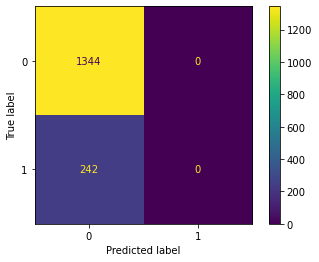

In [15]:
confusiondisplay(y_test, y_pred_dummy, 'Dummy')

Model 1 Confusion Matrix


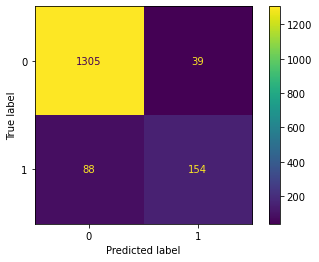

In [16]:
confusiondisplay(y_test, y_pred_1, 'Model 1')

Model 2 Confusion Matrix


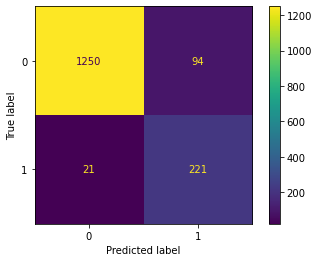

In [17]:
confusiondisplay(y_test, y_pred_2, 'Model 2')

In [18]:
def plotrocauc(y_true, y_pred_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    auc_score = roc_auc_score(y_true, y_pred_probs)
    print('ROC - AUC score for ' + model_name + ' is ' + str(auc_score))
    

ROC - AUC score for Dummy is 0.5


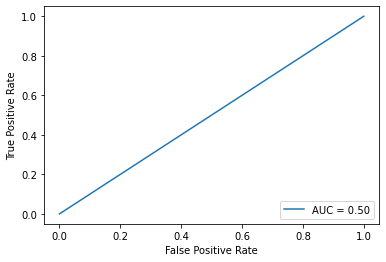

In [19]:
plotrocauc(y_test, y_pred_proba_dummy[ :,1], 'Dummy')

ROC - AUC score for Model 1 is 0.942053448445494


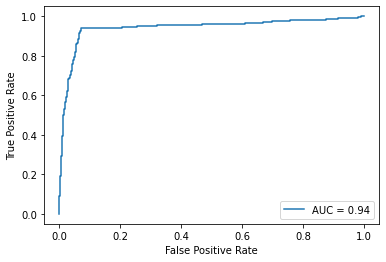

In [20]:
plotrocauc(y_test, y_pred_proba_1[ :,1], 'Model 1')


ROC - AUC score for Model 2 is 0.9418351534828807


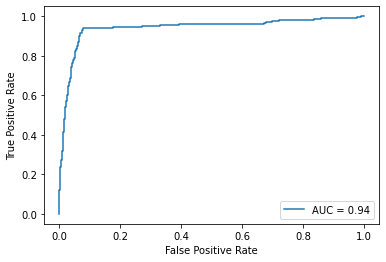

In [21]:
plotrocauc(y_test, y_pred_proba_2[ :,1], 'Model 2')

Okay, so what's the deal with this PR curve?  Where a ROC curve charts true and false positive rates, the Precision-Recall curve charts... precision and recall. 

Remember that Precision is the same as the number of true positives divided by the total number of both true and false positives. This is the same as the 'TPR' in the ROC-AUC metric.  A high precision means that you are rarely missing positive cases. As we've seen, you can get more of the true positives by trading off, with a corresponding growth in false negatives. 

So the real difference with PR-AUC and ROC-AUC is Recall, or the number of true positives / true positives + false negatives. To increase recall, you need to weed out false negatives. 

|                   | Guessed False |   Guessed True  |
| --------------    | --------------|---------------- |
|**Actually False** |       TN      |        FP       |
|**Actually True**  |       FN      |        TP       |


Precision Recall can be a more useful metric in cases of imbalanced datasets. An ROC-AUC on an imbalanced dataset might 'get away with' an inflated TPR and FPR if the imbalance leads to a relatively 'good' rate of true negatives. 


Consider a case like this:

|                     | Guessed Yellow    | Guessed Green      |
| --------------      | ------------------|------------------- |
| **Actually Yellow** |     TN = 900      |        FP = 90     |
| **Actually Green**  |     FN = 1        |        TP = 9      |

Now, how well do we think this model worked? Well, if we're trying to find Greens, we did pretty well. And while we had a lot of yellows in the green guesses, we were fairly discriminating. Mostly, we were able to class the Yellows into the right column.


Let's see how this would reflect in our ROC-AUC curve at whatever threshold we're using. In this case our FPR is **FP / (FP + TN)** or 1/(1+900), or .1%. The large amount of 'True Yellows' in the sample lead this to have a 'good' FPR score, maybe better than we might feel is justified. The large number of 'Actually Yellow' guesses will 'stick' the curve to the left. (Low FPR is good)

The TPR **TP/(TP+FN)** is also good at (9/(9+1)), or 90%. That's fairly good. Although we could use the ROC to find a good threshold with our model, the ROC-AUC score in general will be skewed by this class imbalance. (High TPR is good)

Let's compare that to the Precision - Recall metric.  Recall is the same as TPR **TP / (TP + FN)** or 9/(9+1), or 90%. As we said, that's not bad. 

Precision on the other hand is **TP / (TP + FP)**, or 9/(9+90), around 9%. This is not so good, we want a high Precision. 

The PR-Curve 'looks at' the upper left, upper right, and lower left cells, but doesn't look at the lower right. In other words, **TN** is not accounted for in the PR-AUC. 

Let's see how this plays out with our taxis models from above.

In [22]:
def plotprauc(fitestimator, xtest, y_true, model_name, y_pred_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
    PrecisionRecallDisplay.from_estimator(estimator = fitestimator, X = xtest, y = y_true, name = model_name)
    auc_score = auc(recall, precision)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

    #Commenting this out until I can make the auc_score play nice with the dummy
    #print('PR - AUC score for ' + model_name + ' is ' + str(auc_score))
    

Best Threshold=0.152681, F-Score=0.265


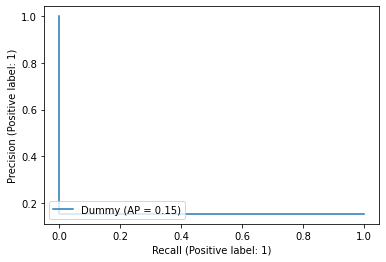

In [23]:
plotprauc(baselinemodel, X_test_enscaled, y_test,'Dummy', y_pred_proba_dummy[ :,1])

Best Threshold=0.156882, F-Score=0.806


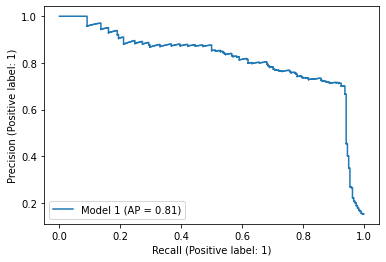

In [24]:
plotprauc(lrmodel1, X_test_enscaled, y_test,  'Model 1', y_pred_proba_1[ :,1])

Best Threshold=0.156882, F-Score=0.806


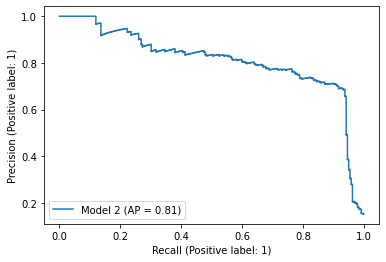

In [25]:
plotprauc(lrmodel2, X_test_enscaled, y_test,  'Model 2', y_pred_proba_1[ :,1])

So far, so good, we're just trying out a different metric, and seeing a pretty similar performance. So what's the big deal?  

Remember that the ROC AUC rewards lots of true negatives and the PR Curve doesn't. That really matters if we have an extremely imbalanced dataset. Let's explore that!

In [26]:
# Now let's really imbalance this model!

y_green = y_test.loc[y_test== 1].sample(frac=.1,  random_state=14)
y_yellow = y_test.loc[y_test == 0]
y_yellow
new_y_test = pd.DataFrame(pd.concat([y_green, y_yellow]))
new_test_df = new_y_test.join(X_test)


In [27]:
#Recalculating y_pred using the new test set

new_y_test = new_test_df.color

new_X_test = new_test_df.drop(labels = 'color', axis = 1)

#I'll run my X_test data into my pseudopipeline

new_X_test_enscaled = pseudopipeline(new_X_test, ohe1, scaler1)

Note that we haven't touched our training data, the models, or even the X-test data associated with each point. So we're working with the same models with the same coefficients guess on the same points... only with fewer 'green' taxis in the test data.

In [28]:
#Generating predictions with default threshold
new_y_pred_dummy = baselinemodel.predict(new_X_test_enscaled)
new_y_pred_1 = lrmodel1.predict(new_X_test_enscaled)
new_y_pred_2 = lrmodel2.predict(new_X_test_enscaled)



#Generating my predictions as probabilities
new_y_pred_proba_dummy = baselinemodel.predict_proba(new_X_test_enscaled)
new_y_pred_proba_1 = lrmodel1.predict_proba(new_X_test_enscaled)
new_y_pred_proba_2 = lrmodel2.predict_proba(new_X_test_enscaled)


If you compare these confusion matrixes to the ones from above, note that the upper row hasn't changed, but the bottom rows have.

Dummy Confusion Matrix


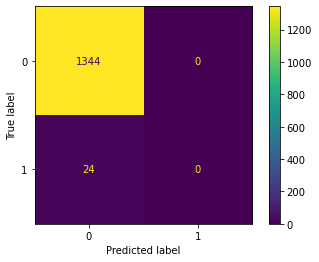

In [29]:
confusiondisplay(new_y_test, new_y_pred_dummy, 'Dummy')

Model 1 Confusion Matrix


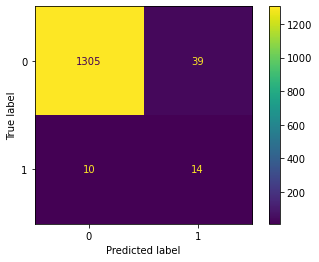

In [30]:
confusiondisplay(new_y_test, new_y_pred_1, 'Model 1')

Model 2 Confusion Matrix


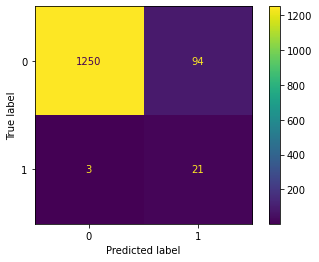

In [31]:
confusiondisplay(new_y_test, new_y_pred_2, 'Model 2')

ROC - AUC score for Dummy is 0.5


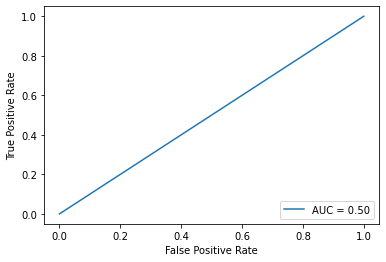

In [32]:
plotrocauc(new_y_test, new_y_pred_proba_dummy[ :,1], 'Dummy')

ROC - AUC score for Model 1 is 0.8987785218253969


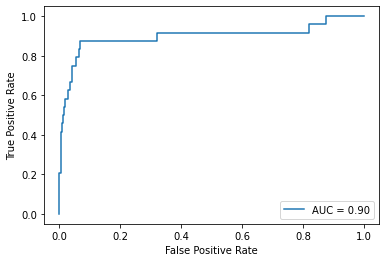

In [33]:
plotrocauc(new_y_test, new_y_pred_proba_1[ :,1], 'Model 1')

ROC - AUC score for Model 2 is 0.8957403273809523


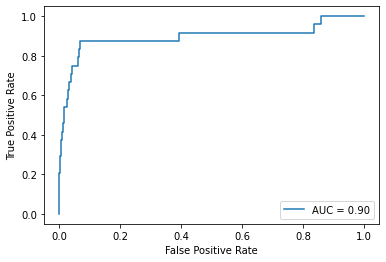

In [34]:
plotrocauc(new_y_test, new_y_pred_proba_2[ :,1], 'Model 2')

We got more or less the same result. The AUC went down slightly, but if we optimize for ROC-AUC the first model is still winning by a hair. 


#### Okay, so the ROC-AUC doesn't seem too affected, let's try the PR-AUC

Best Threshold=0.152681, F-Score=0.034


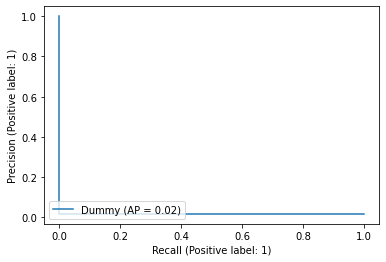

In [35]:
plotprauc(baselinemodel, new_X_test_enscaled, new_y_test,'Dummy', new_y_pred_proba_dummy[ :,1])

Best Threshold=0.818951, F-Score=0.468


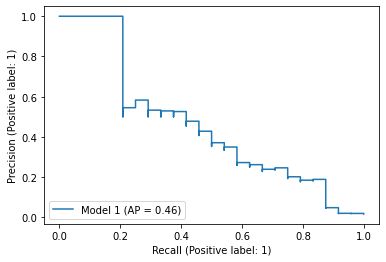

In [36]:
plotprauc(lrmodel1, new_X_test_enscaled, new_y_test,'Model 1', new_y_pred_proba_1[ :,1])

Best Threshold=0.978502, F-Score=0.474


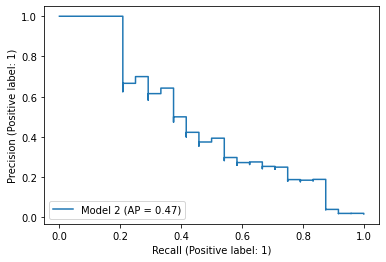

In [37]:
plotprauc(lrmodel2, new_X_test_enscaled, new_y_test,'Model 2', new_y_pred_proba_2[ :,1])

First, the PR curve gets crazy at this level of imbalance. That isn't necessarily a bad thing. This is happening because the PR isn't getting credit for the large number of True Negatives that are benefiting the ROC-AUC. Here we can see that prioritizing the PR-AUC would have us leaning more towards the second model instead of the first, in contrast to the ROC-AUC. 

In a case like this, that may well be the correct choice!  Let's look at the model's in the confusion matrixes again:

Model 1 Confusion Matrix


Model 2 Confusion Matrix


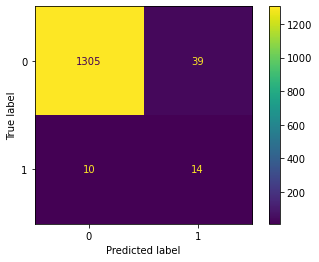

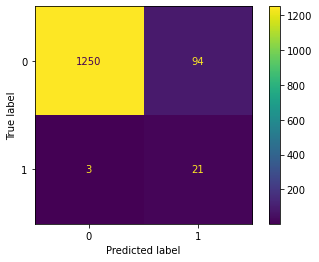

In [38]:
confusiondisplay(new_y_test, new_y_pred_1, 'Model 1')
confusiondisplay(new_y_test, new_y_pred_2, 'Model 2')

Model 1 (at this default threshold anyway) makes fewer mistakes overall (39+10), and in general has way fewer false positives. But! The second model has far fewer false negatives. So which is better? As ever, it comes to the bussiness problem and stakeholder's needs, but the issue remains that a ROC-AUC will credit models with imbalanced datasets for 'free' true negatives, which generally makes it inappropriate as a target for optimization in those cases.